In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from malbecs.preprocess import meteo

In [2]:
path = '../../data/raw/DATOS_METEO.TXT'
meteo_data = meteo.load_meteo_data(path)

In [3]:
meteo_data.columns

Index(['validTimeUtc', 'precip1Hour', 'precip6Hour', 'precip24Hour',
       'precip2Day', 'precip3Day', 'precip7Day', 'precipMtd', 'precipYtd',
       'pressureChange', 'pressureMeanSeaLevel', 'relativeHumidity',
       'snow1Hour', 'snow6Hour', 'snow24Hour', 'snow2Day', 'snow3Day',
       'snow7Day', 'snowMtd', 'snowSeason', 'snowYtd', 'temperature',
       'temperatureChange24Hour', 'temperatureMax24Hour',
       'temperatureMin24Hour', 'temperatureDewPoint', 'temperatureFeelsLike',
       'uvIndex', 'visibility', 'windDirection', 'windGust', 'windSpeed',
       'ID_ESTACION'],
      dtype='object')

# Variables a Calcular:

1.  

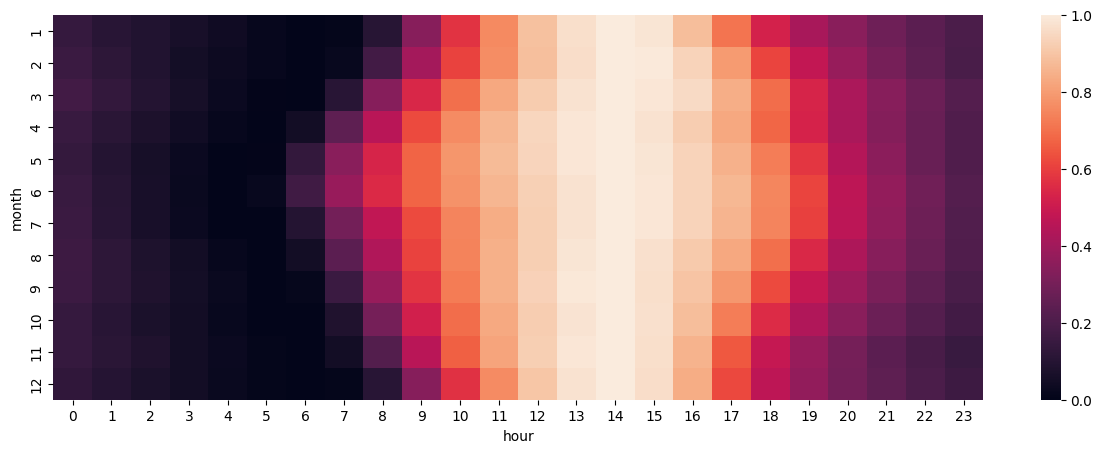

In [4]:
plt.figure(figsize=(15,5))

sns.heatmap(

(
    meteo_data
    .groupby([
    meteo_data.validTimeUtc.dt.hour,
    meteo_data.validTimeUtc.dt.month,
    ]).agg({
        "temperature":"mean"
    })
    .unstack(1)
    .droplevel(0,1)
    .pipe(lambda df: (df-df.min(axis=0))/(df.max(axis=0) - df.min(axis=0)))
    .T
)
)
plt.xlabel("hour")
plt.ylabel('month')
plt.show()

In [5]:
# def get_daily_mean_by_hour_range(meteo, col='temperature', from_hour=0, to_hour=24):
#     # 12,16
#     meteo_filtered = meteo.loc[
#         meteo['validTimeUtc'].dt.hour.between(from_hour,to_hour),
#         ['ID_ESTACION','validTimeUtc',col]
#     ]

#     return meteo_filtered.groupby([
#         'ID_ESTACION',
#         pd.to_datetime(meteo_filtered['validTimeUtc'].dt.date)
#     ]).agg({
#         col:"mean"
#     }).reset_index().rename(columns={
#         col:f"{col}_avg_from_{from_hour}_to_{to_hour}",
#         "validTimeUtc":"date"
#     })
     
daytime_temp = meteo.get_daily_mean_by_hour_range(meteo_data, 'temperature', 12, 16)
nighttime_temp = meteo.get_daily_mean_by_hour_range(meteo_data, 'temperature', 1, 5)


In [6]:
temp_features = daytime_temp.merge(
    nighttime_temp, 
    left_on=['ID_ESTACION','date'], 
    right_on=['ID_ESTACION','date']
)
temp_features.columns

Index(['ID_ESTACION', 'date', 'temperature_avg_from_12_to_16',
       'temperature_avg_from_1_to_5'],
      dtype='object')

In [30]:
montly_temp_features = temp_features.groupby([
    'ID_ESTACION',
    temp_features.date.dt.year,
    temp_features.date.dt.month
]).agg({
    "temperature_avg_from_12_to_16":"max",
    "temperature_avg_from_1_to_5":"min"
}).rename(columns={
    "temperature_avg_from_12_to_16":"max_12_to_16_temp",
    "temperature_avg_from_1_to_5":"min_1_to_5_temp"
})
# .unstack(0).plot().legend(bbox_to_anchor=(1, 1))

In [32]:
# montly_temp_features

In [33]:
montly_temp_features.index.names = ['ID_ESTACION', 'year', 'month']

In [34]:
montly_temp_features = montly_temp_features.reset_index()

In [35]:
months=[1,2,3,4,5,6]
montly_temp_features = montly_temp_features[montly_temp_features['month'].isin(months)]

In [36]:
montly_temp_pivot = montly_temp_features.pivot(
    index=['ID_ESTACION',"year"],
    columns=['month'],
    values=['max_12_to_16_temp','min_1_to_5_temp']
).reset_index()

In [37]:
montly_temp_pivot = meteo.flatten_pivot_columns(montly_temp_pivot)

In [39]:
montly_temp_pivot = meteo.fillna_by_group(
    montly_temp_pivot,
    cols=montly_temp_pivot.columns,
    group=['ID_ESTACION']
)

In [41]:
# montly_temp_pivot

In [42]:
montly_temp_pivot.to_csv('../../data/processed/meteo_pro.csv', index=False)

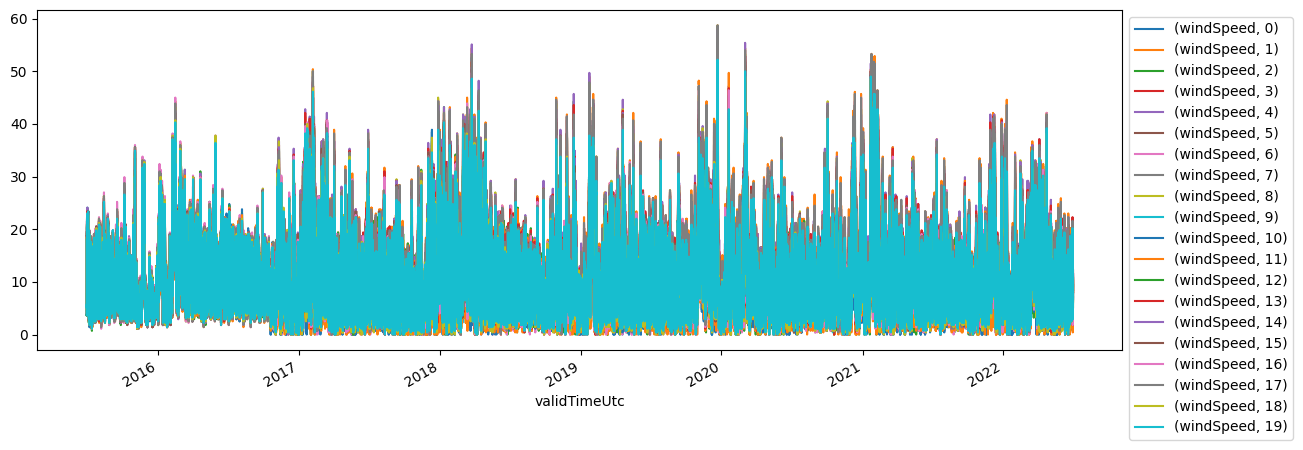

In [20]:
# meteo['windGust']
meteo.groupby(
    [
    'validTimeUtc',   
    'ID_ESTACION'
    ]
).agg({
#  "windGust":"mean"
 "windSpeed":"mean"
}).unstack(1).plot( figsize=(14,5)).legend(bbox_to_anchor=(1, 1))


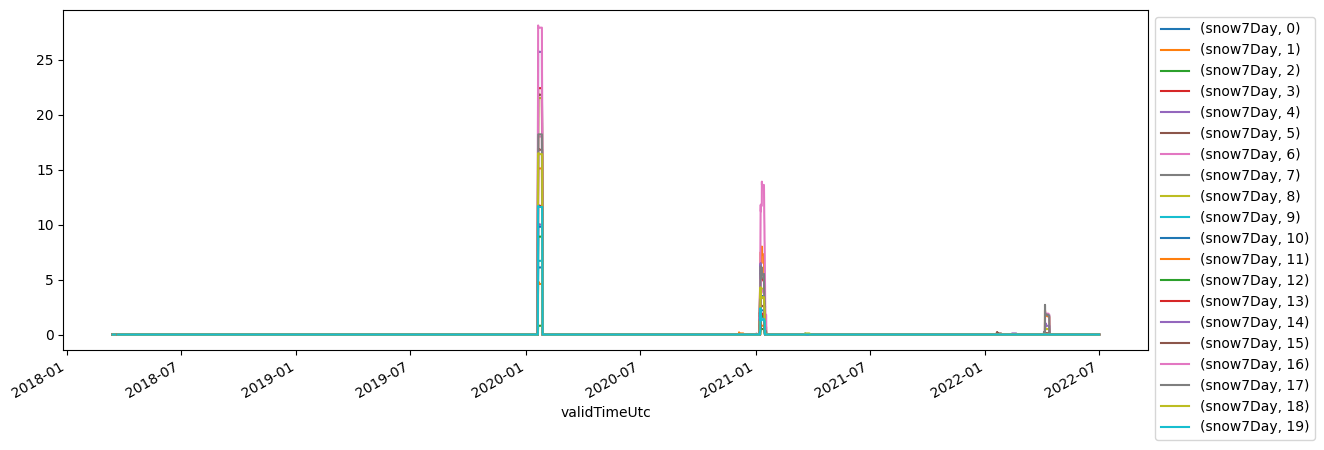

In [8]:
meteo.groupby(
    [
    'validTimeUtc',   
    'ID_ESTACION'
    ]
).agg({
 "snow7Day":"mean"
}).unstack(1).plot( figsize=(14,5)).legend(bbox_to_anchor=(1, 1))


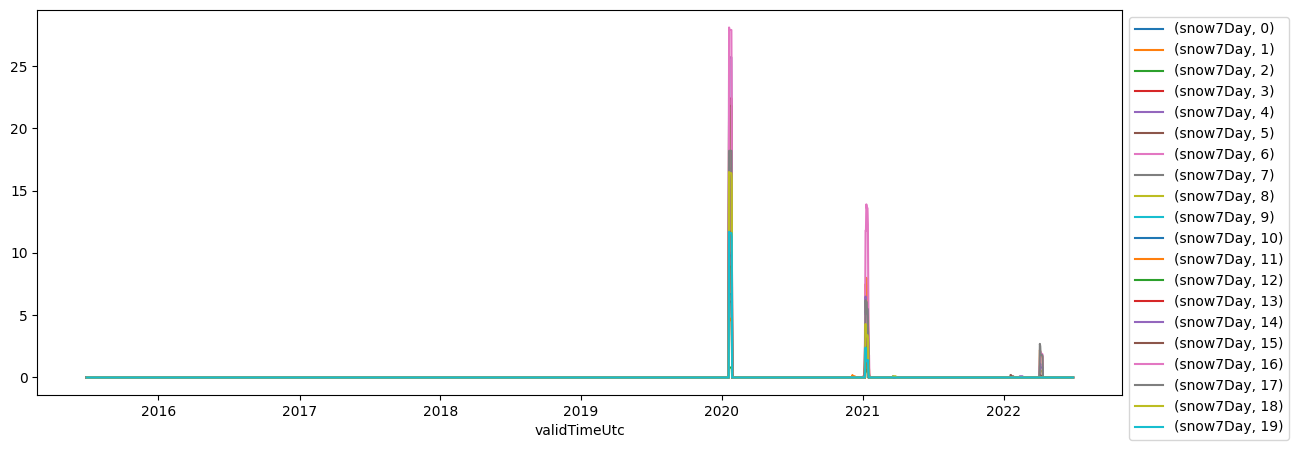

In [11]:
meteo.groupby(
    ['ID_ESTACION',meteo['validTimeUtc'].dt.date]
).agg({
 "snow7Day":"max"
}).fillna(0).unstack(0).plot(figsize=(14,5)).legend(bbox_to_anchor=(1, 1))

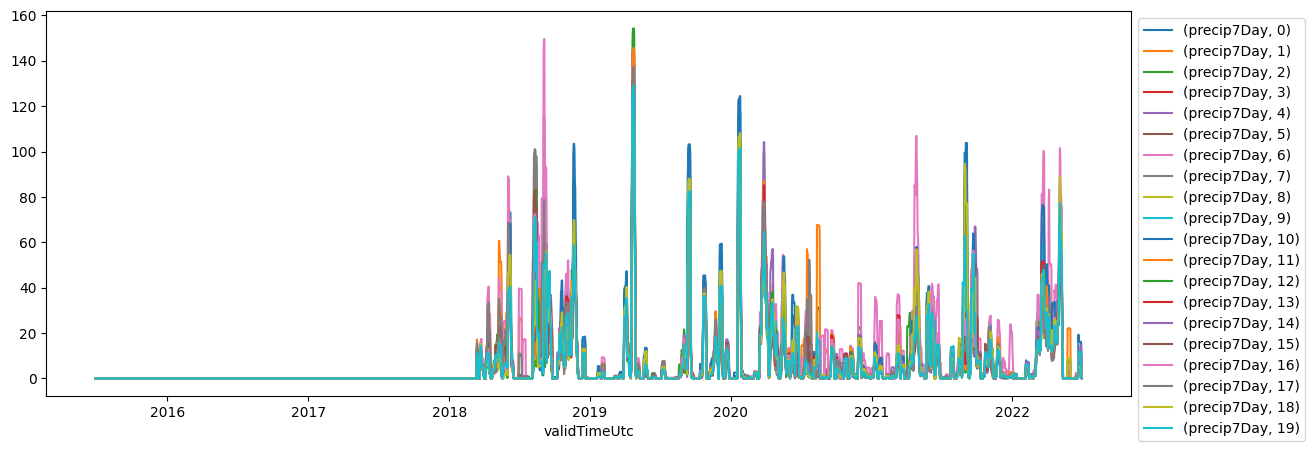

In [12]:
meteo.groupby(
    ['ID_ESTACION',meteo['validTimeUtc'].dt.date]
).agg({
 "precip7Day":"max"
}).fillna(0).unstack(0).plot(figsize=(14,5)).legend(bbox_to_anchor=(1, 1))